In [1]:
import reading
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, InputLayer, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv3D, AveragePooling2D, AveragePooling3D, MaxPooling2D, MaxPooling3D,GlobalAvgPool2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import roc_curve, auc
import os
from tensorflow.keras import layers
from tensorflow.keras import losses

2023-03-17 15:46:44.409210: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 15:46:44.857940: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 15:46:44.857968: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-17 15:46:46.424368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Import dataset

In [2]:
paths_FA= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_FA_image")
paths_MD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_MD_image")
paths_AD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_AD_image")
paths_RD= reading.data_path("Diffusion_parameters_maps-20230215T134959Z-001","corrected_RD_image")

#paths_FA.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
#paths_MD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
#paths_AD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))
#paths_RD.sort(key=lambda x: int(os.path.basename(x).split('_')[3]))

dataset=pd.DataFrame(pd.read_csv('ADNI_dataset_diffusion.csv'))
dataset.sort_values(by=["Subject"],inplace=True,ignore_index=True)
dataset["Path FA"]=paths_FA
dataset["Path MD"]=paths_MD
dataset["Path AD"]=paths_AD
dataset["Path RD"]=paths_RD
pd.set_option("max_colwidth",None)

In [3]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(dataset)

    Subject  Group  Sex   Age  \
0      4002      0    F  74.0   
1      4003      0    F  72.0   
2      4009      1    M  90.0   
3      4018      0    M  76.0   
4      4050      0    M  77.0   
5      4081      0    F  73.0   
6      4089      1    M  74.0   
7      4097      0    F  71.0   
8      4119      0    M  79.0   
9      4121      0    M  89.0   
10     4136      1    M  67.0   
11     4142      1    F  90.0   
12     4148      0    M  73.0   
13     4152      1    M  61.0   
14     4198      0    F  78.0   
15     4201      1    F  64.0   
16     4215      1    M  82.0   
17     4234      0    M  70.0   
18     4254      0    F  86.0   
19     4275      0    M  73.0   
20     4279      0    M  84.0   
21     4282      1    M  90.0   
22     4288      0    F  73.0   
23     4290      0    M  74.0   
24     4307      1    M  79.0   
25     4350      0    M  73.0   
26     4353      1    F  56.0   
27     4369      0    M  68.0   
28     4371      0    M  68.0   
29     437

In [4]:
for i in range(97):
    print(dataset["Group"][i], dataset["Path FA"][i])

0 Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4002/corrected_FA_image/2011-02-28_15_42_50.0/I397180/ADNI_098_S_4002_MR_corrected_FA_image_Br_20131105134057196_S100616_I397180.nii
0 Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4003/corrected_FA_image/2011-03-22_09_23_47.0/I299742/ADNI_098_S_4003_MR_corrected_FA_image_Br_20120421215950180_S102157_I299742.nii
1 Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/016_S_4009/corrected_FA_image/2011-06-18_12_22_12.0/I299644/ADNI_016_S_4009_MR_corrected_FA_image_Br_20120421205831338_S112088_I299644.nii
0 Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4018/corrected_FA_image/2011-04-22_15_36_10.0/I299744/ADNI_098_S_4018_MR_corrected_FA_image_Br_20120421220032350_S105027_I299744.nii
0 Diffusion_parameters_maps-20230215T134959Z-001/Diffusion_parameters_maps/098_S_4050/corrected_FA_image/2011-05-27_15_33_58.0/I299745/ADNI_098_

In [4]:
images_list = []
k_slice = 45

for i, datapath in enumerate(dataset["Path FA"]):
    image_FA = np.asarray(nib.load(dataset["Path FA"][i]).get_fdata())
    image_MD = np.asarray(nib.load(dataset["Path MD"][i]).get_fdata())
    image_AD = np.asarray(nib.load(dataset["Path AD"][i]).get_fdata())
    image = np.stack((image_FA[k_slice], image_MD[k_slice], image_AD[k_slice]), axis=-1)
    images_list.append(image)
    
images = np.array(images_list, dtype='float64')
labels = np.array(dataset["Group"], dtype='int64')

print(np.shape(images))

(97, 110, 110, 3)


Data augmentation

In [5]:
#'''
augmentation_rot = Sequential([layers.RandomRotation((-0.5,0.5))])
augmentation_zoom = Sequential([layers.RandomZoom(0.5)])
augmentation_crop = Sequential([layers.RandomCrop(110, 110, seed=3)])
augmentation_cont = Sequential([layers.RandomContrast(1,seed=5)])
augmentation_zoom2 = Sequential([layers.RandomZoom(0.6)])
augmentation_zoom3 = Sequential([layers.RandomZoom(0.7)])
augmentation_zoom4 = Sequential([layers.RandomZoom(0.65)])
augmentation_cont2 = Sequential([layers.RandomContrast(0.8,seed=8)])





images_rotated = augmentation_rot(images)
images_zoomed = augmentation_zoom(images)
images_croped = augmentation_crop(images)
images_contr= augmentation_cont(images)
images_zoomed2 = augmentation_zoom2(images)
images_zoomed3=augmentation_zoom3(images)
images_zoomed4=augmentation_zoom4(images)
images_contr2= augmentation_cont2(images)



images = np.concatenate((images, images_rotated, images_zoomed, images_croped, images_contr,images_zoomed2,images_zoomed3,images_zoomed4,images_contr2), axis = 0)

labels = np.concatenate((labels, labels, labels,labels,labels,labels,labels,labels,labels))
#'''

2023-03-17 15:46:51.540188: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 15:46:51.540586: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 15:46:51.540616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (francesco-jj): /proc/driver/nvidia/version does not exist
2023-03-17 15:46:51.541658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 15:46:51.602684: W tensorflow/tsl/framework/cpu_allocator_im

2023-03-17 15:46:52.324026: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 14084400 exceeds 10% of free system memory.


2023-03-17 15:46:53.336270: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 14084400 exceeds 10% of free system memory.
2023-03-17 15:46:53.366373: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 28168800 exceeds 10% of free system memory.


2023-03-17 15:46:54.152158: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 14084400 exceeds 10% of free system memory.


2023-03-17 15:46:57.238757: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: loop_body/cond/pfor/cond/branch_executed/_191


Train-Validation-Test splitting

In [6]:
def split_2D():
    X_train, x_test, Y_train, y_test = train_test_split(images[:,:,:], labels, test_size=0.2, random_state=10)
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=20)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [7]:
x_train, y_train, x_val, y_val, x_test, y_test = split_2D()
print(x_train.shape)

(523, 110, 110, 3)


Defining 2.5-D CNN model

In [8]:
def make_2D_CNN_best(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(8, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l1'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=3),
      Dropout(0.3),
      
      Conv2D(16, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l1'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((3,3), strides=3),
      #Dropout(0.1),
      
      
      Flatten(),

      Dense(99, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

In [16]:
def make_2D_CNN(shape=(110, 110, 3)):
  model = Sequential([
      
      Conv2D(8, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l1'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((2,2), strides=3),
      Dropout(0.3),
      
      Conv2D(16, (3,3), padding='valid', input_shape=shape, kernel_regularizer='l1'),
      BatchNormalization(),
      Activation('relu'),
      
      MaxPooling2D((3,3), strides=3),
      #Dropout(0.1),
      
      
      Flatten(),

      Dense(116, activation='relu'),
      #Dropout(0.1),
      Dense(1, activation='sigmoid')
     
  ])
  return model

Create the model

In [17]:
model = make_2D_CNN()
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 108, 108, 8)       224       
                                                                 
 batch_normalization_4 (Batc  (None, 108, 108, 8)      32        
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 108, 108, 8)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 8)        0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 36, 36, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 16)      

Compile and training the model

In [18]:
model.compile(optimizer=SGD(learning_rate=0.01), 
              loss=losses.Hinge(), 
              metrics=['accuracy'])

reduce_on_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)

early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=10)

epochs= 1000
batch_size = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch = round(len(x_train)/batch_size),
                    verbose=1,
                    validation_data=(x_val, y_val),
                    validation_steps=round(len(x_val)/batch_size),
                    callbacks=[reduce_on_plateau, early_stopping])

Epoch 1/1000
52/52 [==============================] - 3s 36ms/step - loss: 2.2679 - accuracy: 0.4865 - val_loss: 2.2133 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 2/1000
52/52 [==============================] - 2s 34ms/step - loss: 2.1904 - accuracy: 0.4893 - val_loss: 2.1467 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 3/1000
52/52 [==============================] - 2s 33ms/step - loss: 2.1349 - accuracy: 0.4834 - val_loss: 2.0822 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 4/1000
52/52 [==============================] - 2s 33ms/step - loss: 2.0660 - accuracy: 0.4854 - val_loss: 2.0193 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 5/1000
52/52 [==============================] - 2s 33ms/step - loss: 2.0030 - accuracy: 0.4854 - val_loss: 1.9578 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 6/1000
52/52 [==============================] - 2s 33ms/step - loss: 1.9084 - accuracy: 0.4951 - val_loss: 1.8947 - val_accuracy: 0.4914 - lr: 0.0100
Epoch 7/1000
52/52 [==============================] - 2s 34ms/st

Show training results on Training set and Validation set

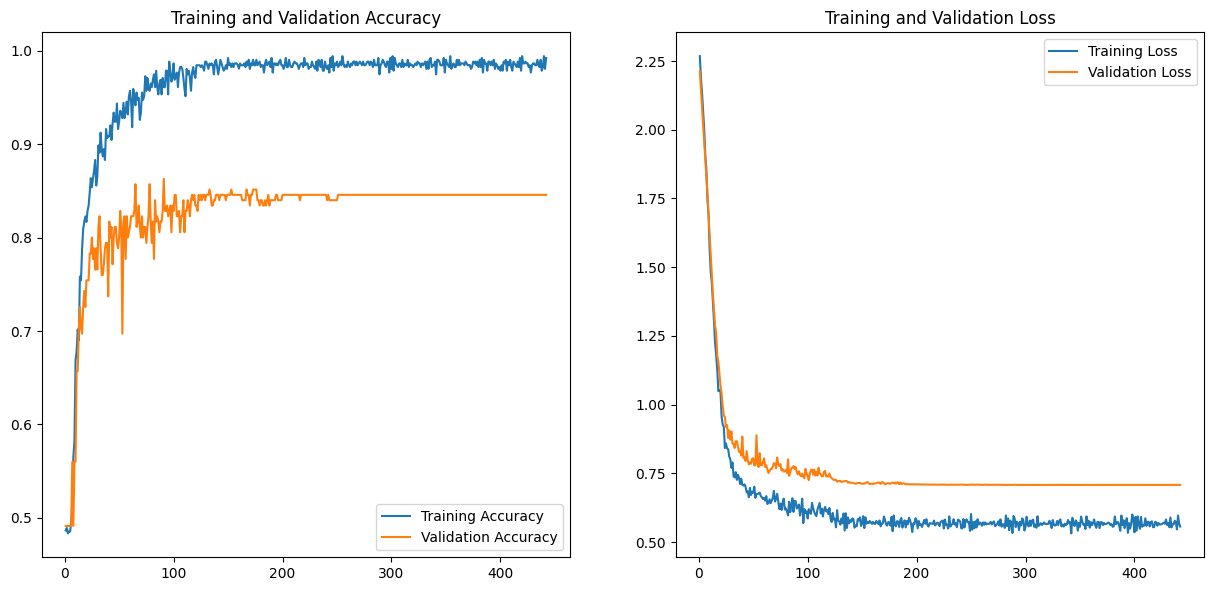

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc)+1)
#Train and validation accuracy 
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Train and validation loss 
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Accuracy ROC

Validation accuracy: 0.846
6/6 [==============================] - 0s 21ms/step
AUC = 0.923


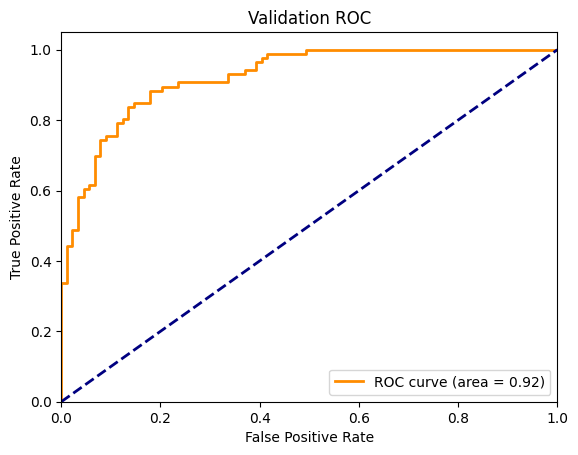

In [20]:
_, val_acc = model.evaluate(x_val, y_val, verbose=0)
print('Validation accuracy: %.3f' % (val_acc))

preds = model.predict(x_val, verbose=1)
#Compute Receiver operating characteristic (ROC)
fpr, tpr, _ = roc_curve(y_val, preds)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

#Plot of a ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC')
plt.legend(loc="lower right")
plt.show()

Test ROC

6/6 [==============================] - 0s 22ms/step - loss: 0.7870 - accuracy: 0.7943

Test accuracy: 0.794
6/6 [==============================] - 0s 24ms/step
AUC = 0.851


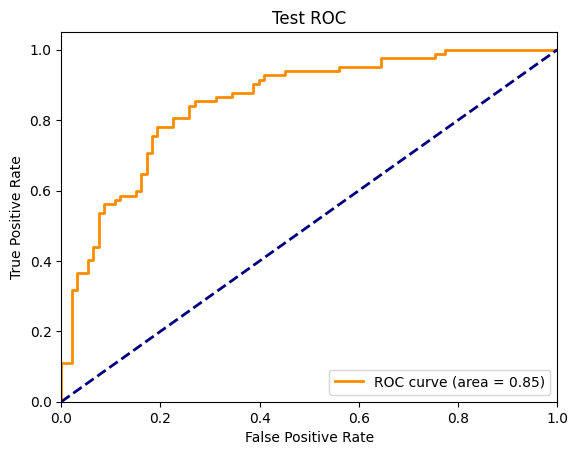

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy: %.3f' % (test_acc))

preds_test = model.predict(x_test, verbose=1)
fpr, tpr, _ = roc_curve(y_test, preds_test)
roc_auc = auc(fpr, tpr)
print('AUC = %.3f'% (roc_auc))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()